In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import ast
import cv2
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16,ResNet50, EfficientNetB0,EfficientNetB3
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Add, Concatenate, UpSampling2D,SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Reshape, GlobalAveragePooling2D, GlobalMaxPooling2D,Activation, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


## Cargar csv 


**1.Carga csv**

Se sacan las coordenadas de las regiones de interés de las imágenes del video 7


In [2]:
file_path = 'C:/Users/andre/Downloads/csv_final_video7.csv'
df = pd.read_csv(file_path)

df.head()

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,surco-rouviere-244.jpg,102026,{},3,0,"{""name"":""rect"",""x"":298,""y"":192,""width"":336,""he...","{""Region"":""vesicula""}"
1,surco-rouviere-244.jpg,102026,{},3,1,"{""name"":""rect"",""x"":259,""y"":367,""width"":135,""he...","{""Region"":""surco""}"
2,surco-rouviere-244.jpg,102026,{},3,2,"{""name"":""rect"",""x"":519,""y"":55,""width"":179,""hei...","{""Region"":""segmento4""}"
3,surco-rouviere-326.jpg,108379,{},3,0,"{""name"":""rect"",""x"":298,""y"":64,""width"":233,""hei...","{""Region"":""vesicula""}"
4,surco-rouviere-326.jpg,108379,{},3,1,"{""name"":""rect"",""x"":142,""y"":250,""width"":170,""he...","{""Region"":""surco""}"


In [3]:
# Asegurarnos de que la columna 'label' exista
df['label'] = df['region_attributes'].apply(lambda x: ast.literal_eval(x).get('Region', ''))

df[['filename', 'label']].head()

,filename,label
0,surco-rouviere-244.jpg,vesicula
1,surco-rouviere-244.jpg,surco
2,surco-rouviere-244.jpg,segmento4
3,surco-rouviere-326.jpg,vesicula
4,surco-rouviere-326.jpg,surco


In [4]:
# Función para convertir las coordenadas del formato JSON a (x_min, y_min, x_max, y_max)
def convert_to_bounding_box(region_shape_attributes):
    shape_dict = ast.literal_eval(region_shape_attributes)
    x_min = shape_dict['x']
    y_min = shape_dict['y']
    x_max = x_min + shape_dict['width']
    y_max = y_min + shape_dict['height']
    return x_min, y_min, x_max, y_max

In [5]:


# Aplicar la función a cada fila del DataFrame y extraer las coordenadas
df['x_min'], df['y_min'], df['x_max'], df['y_max'] = zip(*df['region_shape_attributes'].map(convert_to_bounding_box))

# Asegurarnos de que la columna 'label' existe (si no se ha creado anteriormente)
df['label'] = df['region_attributes'].apply(lambda x: ast.literal_eval(x).get('Region', ''))

# Ahora que las columnas 'x_min', 'y_min', 'x_max', 'y_max', y 'label' están en el DataFrame,
df[['filename', 'x_min', 'y_min', 'x_max', 'y_max', 'label']].head()

,filename,x_min,y_min,x_max,y_max,label
0,surco-rouviere-244.jpg,298,192,634,426,vesicula
1,surco-rouviere-244.jpg,259,367,394,475,surco
2,surco-rouviere-244.jpg,519,55,698,210,segmento4
3,surco-rouviere-326.jpg,298,64,531,470,vesicula
4,surco-rouviere-326.jpg,142,250,312,420,surco


In [6]:
array_filename= df['filename'].unique()

In [7]:
array_filename.shape

(61,)

In [8]:
df.shape

(182, 12)

**Carga csv 2**

Se sacan las coordenadas de las regiones de interés de las imágenes del video 2

In [9]:
file_path2 = './via_export_csv_final.csv'
df2 = pd.read_csv(file_path2)

df2.head()


,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,frame_15090.jpg,115668,{},3,0,"{""name"":""rect"",""x"":476,""y"":138,""width"":153,""he...","{""Region"":""vesicula""}"
1,frame_15090.jpg,115668,{},3,1,"{""name"":""rect"",""x"":338,""y"":277,""width"":132,""he...","{""Region"":""surco""}"
2,frame_15090.jpg,115668,{},3,2,"{""name"":""rect"",""x"":638,""y"":234,""width"":120,""he...","{""Region"":""segmento4""}"
3,frame_15103.jpg,128711,{},3,0,"{""name"":""rect"",""x"":454,""y"":145,""width"":143,""he...","{""Region"":""vesicula""}"
4,frame_15103.jpg,128711,{},3,1,"{""name"":""rect"",""x"":370,""y"":305,""width"":166,""he...","{""Region"":""surco""}"


In [10]:
# Asegurarnos de que la columna 'label' exista
df2['label'] = df2['region_attributes'].apply(lambda x: ast.literal_eval(x).get('Region', ''))

df2[['filename', 'label']].head()


,filename,label
0,frame_15090.jpg,vesicula
1,frame_15090.jpg,surco
2,frame_15090.jpg,segmento4
3,frame_15103.jpg,vesicula
4,frame_15103.jpg,surco


In [11]:
# Aplicar la función a cada fila del DataFrame y extraer las coordenadas
df2['x_min'], df2['y_min'], df2['x_max'], df2['y_max'] = zip(*df2['region_shape_attributes'].map(convert_to_bounding_box))

# Asegurarnos de que la columna 'label' existe (si no se ha creado anteriormente)
df2['label'] = df2['region_attributes'].apply(lambda x: ast.literal_eval(x).get('Region', ''))

# Ahora que las columnas 'x_min', 'y_min', 'x_max', 'y_max', y 'label' están en el DataFrame,
df2[['filename', 'x_min', 'y_min', 'x_max', 'y_max', 'label']].head()


,filename,x_min,y_min,x_max,y_max,label
0,frame_15090.jpg,476,138,629,475,vesicula
1,frame_15090.jpg,338,277,470,446,surco
2,frame_15090.jpg,638,234,758,382,segmento4
3,frame_15103.jpg,454,145,597,468,vesicula
4,frame_15103.jpg,370,305,536,439,surco


In [12]:
array_filename2= df2['filename'].unique()
array_filename2.shape

(835,)

In [13]:
df2.shape

(2505, 12)

In [14]:
merged_df = pd.concat([df, df2], ignore_index=True)
merged_df.head()

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes,label,x_min,y_min,x_max,y_max
0,surco-rouviere-244.jpg,102026,{},3,0,"{""name"":""rect"",""x"":298,""y"":192,""width"":336,""he...","{""Region"":""vesicula""}",vesicula,298,192,634,426
1,surco-rouviere-244.jpg,102026,{},3,1,"{""name"":""rect"",""x"":259,""y"":367,""width"":135,""he...","{""Region"":""surco""}",surco,259,367,394,475
2,surco-rouviere-244.jpg,102026,{},3,2,"{""name"":""rect"",""x"":519,""y"":55,""width"":179,""hei...","{""Region"":""segmento4""}",segmento4,519,55,698,210
3,surco-rouviere-326.jpg,108379,{},3,0,"{""name"":""rect"",""x"":298,""y"":64,""width"":233,""hei...","{""Region"":""vesicula""}",vesicula,298,64,531,470
4,surco-rouviere-326.jpg,108379,{},3,1,"{""name"":""rect"",""x"":142,""y"":250,""width"":170,""he...","{""Region"":""surco""}",surco,142,250,312,420


In [15]:
merged_df.tail()

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes,label,x_min,y_min,x_max,y_max
2682,frame_7775.jpg,105868,{},3,1,"{""name"":""rect"",""x"":314,""y"":334,""width"":123,""he...","{""Region"":""surco""}",surco,314,334,437,402
2683,frame_7775.jpg,105868,{},3,2,"{""name"":""rect"",""x"":542,""y"":222,""width"":68,""hei...","{""Region"":""segmento4""}",segmento4,542,222,610,293
2684,frame_7786.jpg,103277,{},3,0,"{""name"":""rect"",""x"":372,""y"":13,""width"":132,""hei...","{""Region"":""vesicula""}",vesicula,372,13,504,325
2685,frame_7786.jpg,103277,{},3,1,"{""name"":""rect"",""x"":292,""y"":321,""width"":127,""he...","{""Region"":""surco""}",surco,292,321,419,407
2686,frame_7786.jpg,103277,{},3,2,"{""name"":""rect"",""x"":540,""y"":240,""width"":74,""hei...","{""Region"":""segmento4""}",segmento4,540,240,614,295


In [16]:
merged_df.shape

(2687, 12)

In [17]:
print(len(merged_df['filename'].unique()))

896


## **Cargar Imágenes**

In [18]:
import os


filenames_from_df = merged_df['filename'].unique()

image_directory = 'durante-cirugia'


all_files_in_directory = os.listdir(image_directory)

files_to_delete = [f for f in all_files_in_directory if f not in filenames_from_df]


for file in files_to_delete:
    file_path = os.path.join(image_directory, file)
    if os.path.isfile(file_path): 
        os.remove(file_path)
        print(f"Archivo {file} eliminado.")
    else:
        print(f"{file} no es un archivo.")

print("Proceso de eliminación completado.")


Proceso de eliminación completado.


In [19]:
class_folders = [
        'antes-cirugia-grande',
        'durante-cirugia',
        'despues-cirugia-grande'
]

In [20]:
def ensure_directory_exists(directory):
    """
    Crea el directorio si no existe.
    
    Parámetros:
    -----------
    directory : str
        La ruta del directorio.
    """
    if not os.path.exists(directory):
        os.makedirs(directory)

In [21]:
def get_image_filenames(image_dirs):
    """
    Obtiene los nombres de los archivos de imagen .jpg de múltiples directorios.
    
    Parámetros:
    -----------
    image_dirs : list
        Lista de rutas de los directorios que contienen las imágenes.
        
    Retorno:
    --------
    list : Lista de nombres de archivos .jpg.
    """
    image_filenames = []
    for image_dir in image_dirs:
        image_filenames += [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    return image_filenames

## **Procesamiento de la imágenes**

Se redimensionan a un tamaño de 224x224,se normalizan y adicionamente se obtienen las coordenadas de cada región de la imagen

In [22]:
def read_imageResize_with_labels(df, image_dirs, target_size=(224, 224)):
    """
    Lee imágenes de múltiples directorios, las redimensiona a 224x224 píxeles y las etiqueta según 
    los valores en el DataFrame. Las imágenes son procesadas en RGB.

    Parámetros:
    -----------
    df : pandas.DataFrame
        DataFrame que contiene la información de las imágenes y coordenadas.
    image_dirs : list
        Lista de rutas de los directorios que contienen las imágenes.
    target_size : tuple, opcional
        Tamaño al que se redimensionarán las imágenes. Por defecto es (224, 224).

    Retorno:
    --------
    tuple: 
        - np.array: Un array de NumPy con las imágenes redimensionadas.
        - dict: Un diccionario con los bounding boxes y las etiquetas correspondientes a las imágenes.
    """
    images_now = []
    bbox_targets = []
    class_targets = []

    image_filenames = get_image_filenames(image_dirs)

    for name_image in image_filenames:

        image_path = None
        for image_dir in image_dirs:
            possible_path = os.path.join(image_dir, name_image)
            if os.path.exists(possible_path):
                image_path = possible_path
                break

        if image_path is None:
            print(f"Error: No se pudo encontrar la imagen {name_image}")
            continue

        image = cv2.imread(image_path)
        if image is None:
            print(f"Advertencia: No se pudo leer la imagen {image_path}")
            continue

        height, width = image.shape[:2]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)
        image = image / 255.0

        df_image = df[df['filename'] == name_image]

        # Verificar si hay regiones en la imagen
        if df_image.empty:
            # Imagen sin regiones: asignar etiquetas de una nueva clase "sin regiones" (ejemplo: clase 3)
            bboxes = [[0, 0, 0, 0] for _ in range(3)]
            labels = [3 for _ in range(3)]  
        else:
            # Imagen con regiones: procesar normalmente
            bboxes = []
            labels = []
            for _, row in df_image.iterrows():
                label_map = {'vesicula': 0, 'surco': 1, 'segmento4': 2}
                label = label_map.get(row['label'], 3)  # Clase especial "sin regiones" si no es válida
                x_scale = target_size[0] / width
                y_scale = target_size[1] / height

                x_min = row['x_min'] * x_scale
                y_min = row['y_min'] * y_scale
                x_max = row['x_max'] * x_scale
                y_max = row['y_max'] * y_scale

                bbox = [x_min, y_min, x_max, y_max]
                bboxes.append(bbox)
                labels.append(label)

            # Asegurarse de que cada imagen tenga 3 regiones, si no, rellenar con valores vacíos
            while len(bboxes) < 3:
                bboxes.append([0, 0, 0, 0]) 
                labels.append(3)  

        images_now.append(image)
        bbox_targets.append(bboxes)
        class_targets.append(tf.keras.utils.to_categorical(labels, num_classes=4))  # 4 clases ahora (0, 1, 2, 3)

    images_now = np.array(images_now)
    bbox_targets = np.array(bbox_targets)
    class_targets = np.array(class_targets)

    return images_now, {"bounding_box": bbox_targets, "class_label": class_targets}


In [23]:

images, targets = read_imageResize_with_labels(merged_df,class_folders)



In [24]:

print(f"Número de imágenes: {images.shape[0]}")
print(f"Tamaño de cada imagen: {images.shape[1:]}")


primera_llave = next(iter(targets))
primer_valor = targets[primera_llave]


Número de imágenes: 2900
Tamaño de cada imagen: (224, 224, 3)


In [25]:
print(type(images[0]))

<class 'numpy.ndarray'>


In [26]:
def inspect_random_targets(targets, num_items=5):
    """
    Inspecciona 'num_items' elementos aleatorios de targets para visualizar 
    los bounding boxes y las etiquetas de clase.
    
    Parámetros:
    ----------
    targets : dict
        Diccionario que contiene 'bounding_box' y 'class_label'.
    num_items : int, opcional
        Número de elementos a visualizar.
    """
    bounding_boxes = targets['bounding_box']
    class_labels = targets['class_label']
    

    random_indices = np.random.choice(len(bounding_boxes), num_items, replace=False)
    
    for i in random_indices:
        print(f"--- Imagen {i+1} ---")
        
        print(f"Bounding Boxes (imagen {i+1}):")
        for bbox in bounding_boxes[i]:
            print(f"x_min: {bbox[0]}, y_min: {bbox[1]}, x_max: {bbox[2]}, y_max: {bbox[3]}")
        
        print(f"Class Labels (imagen {i+1}):")
        for label in class_labels[i]:
            label_index = np.argmax(label)
           
            if label_index == 3:
                label_name = 'sin regiones'
            else:
                label_name = 'vesicula' if label_index == 0 else ('surco' if label_index == 1 else 'segmento4')
                
            print(f"Label: {label_index} ({label_name})")
        
        print("\n")


In [27]:

inspect_random_targets(targets, num_items=3)

--- Imagen 1014 ---
Bounding Boxes (imagen 1014):
x_min: 77.37704918032787, y_min: 5.6, x_max: 137.18032786885246, y_max: 142.33333333333334
x_min: 91.8032786885246, y_min: 146.53333333333333, x_max: 123.01639344262296, y_max: 172.2
x_min: 142.1639344262295, y_min: 79.33333333333333, x_max: 167.344262295082, y_max: 156.33333333333334
Class Labels (imagen 1014):
Label: 0 (vesicula)
Label: 1 (surco)
Label: 2 (segmento4)


--- Imagen 870 ---
Bounding Boxes (imagen 870):
x_min: 0.0, y_min: 0.0, x_max: 0.0, y_max: 0.0
x_min: 0.0, y_min: 0.0, x_max: 0.0, y_max: 0.0
x_min: 0.0, y_min: 0.0, x_max: 0.0, y_max: 0.0
Class Labels (imagen 870):
Label: 3 (sin regiones)
Label: 3 (sin regiones)
Label: 3 (sin regiones)


--- Imagen 1797 ---
Bounding Boxes (imagen 1797):
x_min: 75.27868852459017, y_min: 41.53333333333333, x_max: 109.9016393442623, y_max: 167.53333333333333
x_min: 79.73770491803279, y_min: 177.33333333333334, x_max: 104.91803278688525, y_max: 203.46666666666667
x_min: 108.59016393442623,

In [28]:
print(images.shape)

(2900, 224, 224, 3)


In [29]:
np.max(images[1852])

1.0

In [30]:
targets['bounding_box'][1852]

array([[ 56.39344262,  16.8       , 118.29508197, 219.33333333],
       [ 35.93442623,  98.        ,  57.18032787, 175.93333333],
       [109.37704918,  17.26666667, 169.44262295, 135.8       ]])

In [31]:
def visualize_bounding_boxes(images, targets, num_images=5, columns=2):
    """
    Visualiza un número determinado de imágenes con sus correspondientes cuadros delimitadores
    y etiquetas de clase. No dibuja cuadros ni etiquetas si la clase es inválida (-1 o 3).

    Parámetros:
    -----------
    images : numpy.ndarray
        Array de imágenes.
    targets : dict
        Diccionario que contiene los cuadros delimitadores ('bounding_box') y etiquetas ('class_label').
    num_images : int, opcional
        Número de imágenes a visualizar.
    columns : int, opcional
        Número de columnas en la visualización de subplots.
    """

    
    random_indices = np.random.choice(len(images), num_images, replace=False)

    
    rows = (num_images + columns - 1) // columns


    fig, axes = plt.subplots(rows, columns, figsize=(15, 5 * rows))
    axes = axes.flatten()  

    for idx, i in enumerate(random_indices):
        ax = axes[idx]
        ax.imshow(images[i])
        bbox_list = targets['bounding_box'][i]
        class_list = targets['class_label'][i]

        for bbox, class_label in zip(bbox_list, class_list):
            label = np.argmax(class_label)

            # Si la etiqueta es -1 o 3 (sin regiones), no dibujar cuadros
            if label == -1 or label == 3:
                continue  


            color = 'red' if label == 0 else ('blue' if label == 1 else 'green')
            label_name = 'vesicula' if label == 0 else ('surco' if label == 1 else 'segmento4')


            ax.add_patch(plt.Rectangle(
                (bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                edgecolor=color, facecolor='none', linewidth=2))

            # Añadir el texto de la etiqueta
            ax.text(bbox[0], bbox[1] - 10, f"{label_name}", color=color, fontsize=12,
                    bbox=dict(facecolor='yellow', alpha=0.5))
        
        ax.axis('off')  

   
    for idx in range(num_images, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()



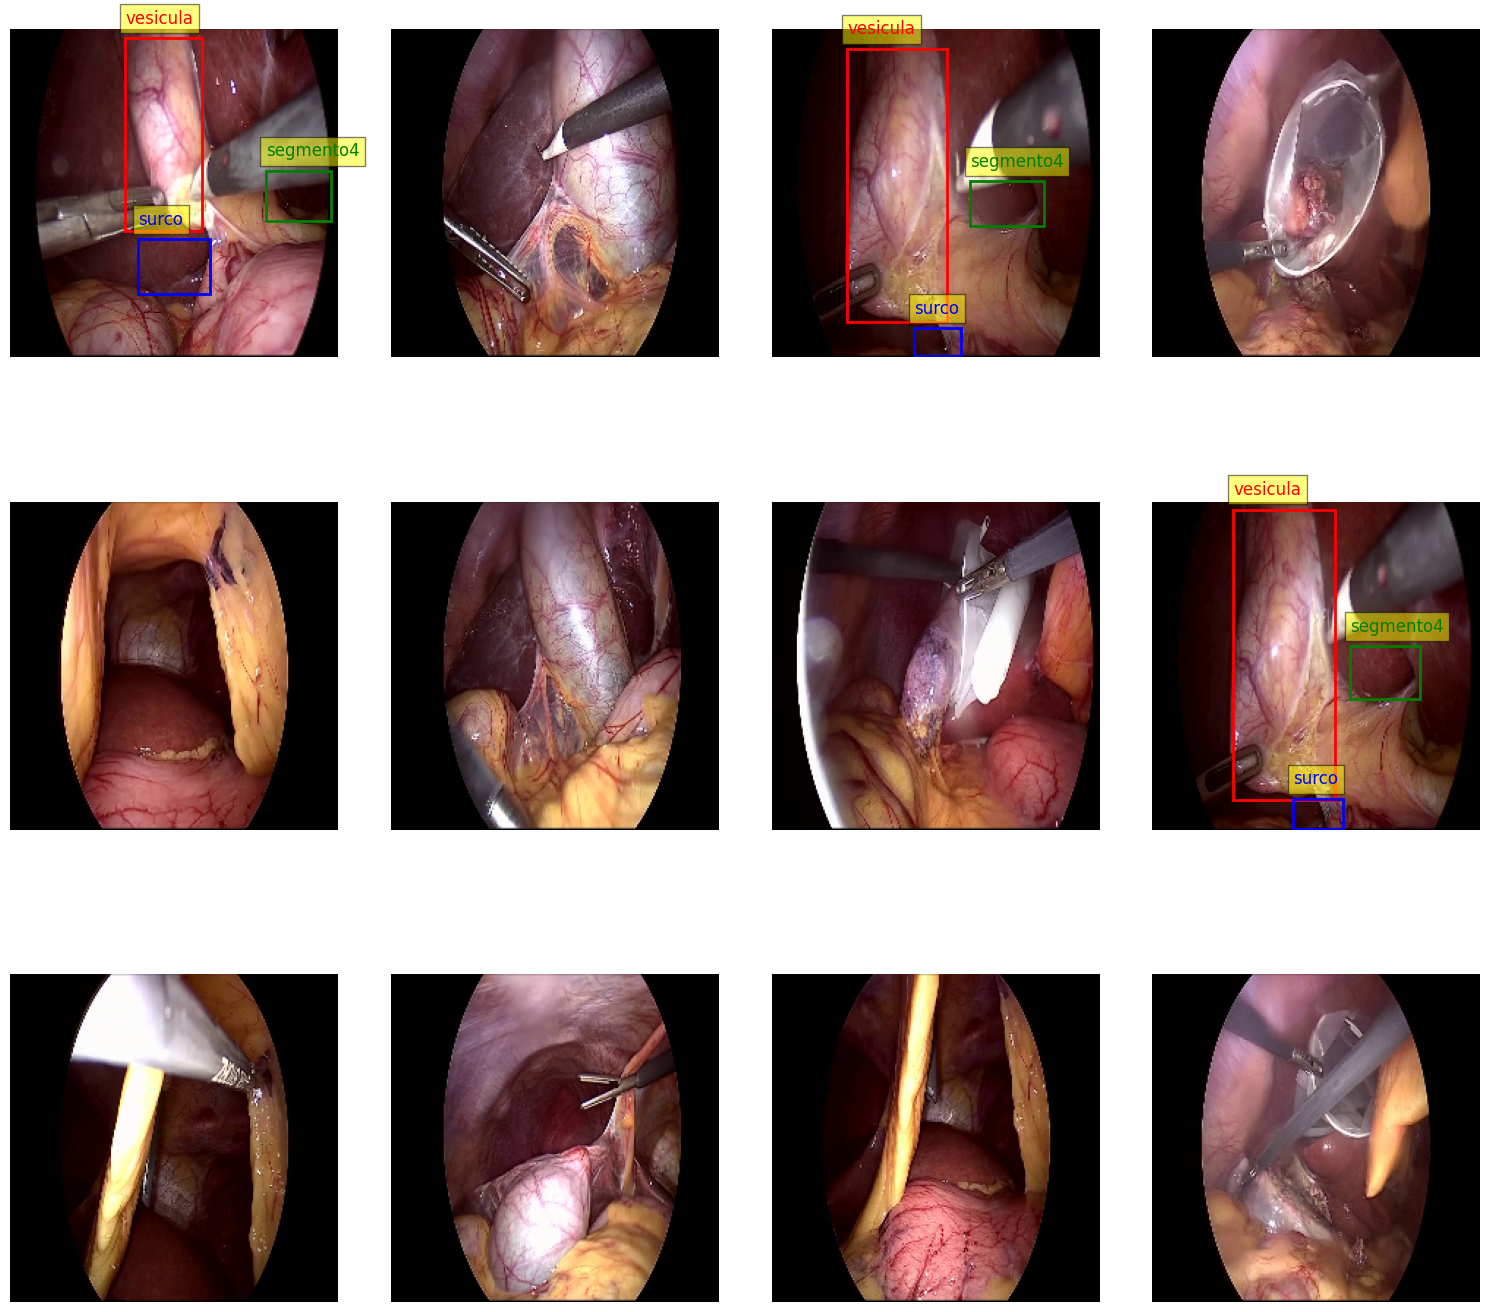

In [32]:
visualize_bounding_boxes(images, targets, num_images=12, columns=4)

## **División train-test**

In [33]:
from sklearn.model_selection import train_test_split

bounding_boxes = targets['bounding_box']
class_labels = targets['class_label']


X_train, X_val, bbox_train, bbox_val, class_train, class_val = train_test_split(
    images, bounding_boxes, class_labels, test_size=0.2, random_state=42
)


train_targets = {
    'bounding_box': bbox_train,
    'class_label': class_labels
}

val_targets = {
    'bounding_box': bbox_val,
    'class_label': class_labels
}


print(f'Conjunto de entrenamiento: {len(X_train)} imágenes, {len(train_targets["bounding_box"])} bounding boxes')
print(f'Conjunto de validación: {len(X_val)} imágenes, {len(val_targets["bounding_box"])} bounding boxes')
print(f"Shape train {class_labels.shape}")

Conjunto de entrenamiento: 2320 imágenes, 2320 bounding boxes
Conjunto de validación: 580 imágenes, 580 bounding boxes
Shape train (2900, 3, 4)


In [34]:
np.array(train_targets['bounding_box']).shape


(2320, 3, 4)

In [35]:
np.array(val_targets['bounding_box']).shape

(580, 3, 4)

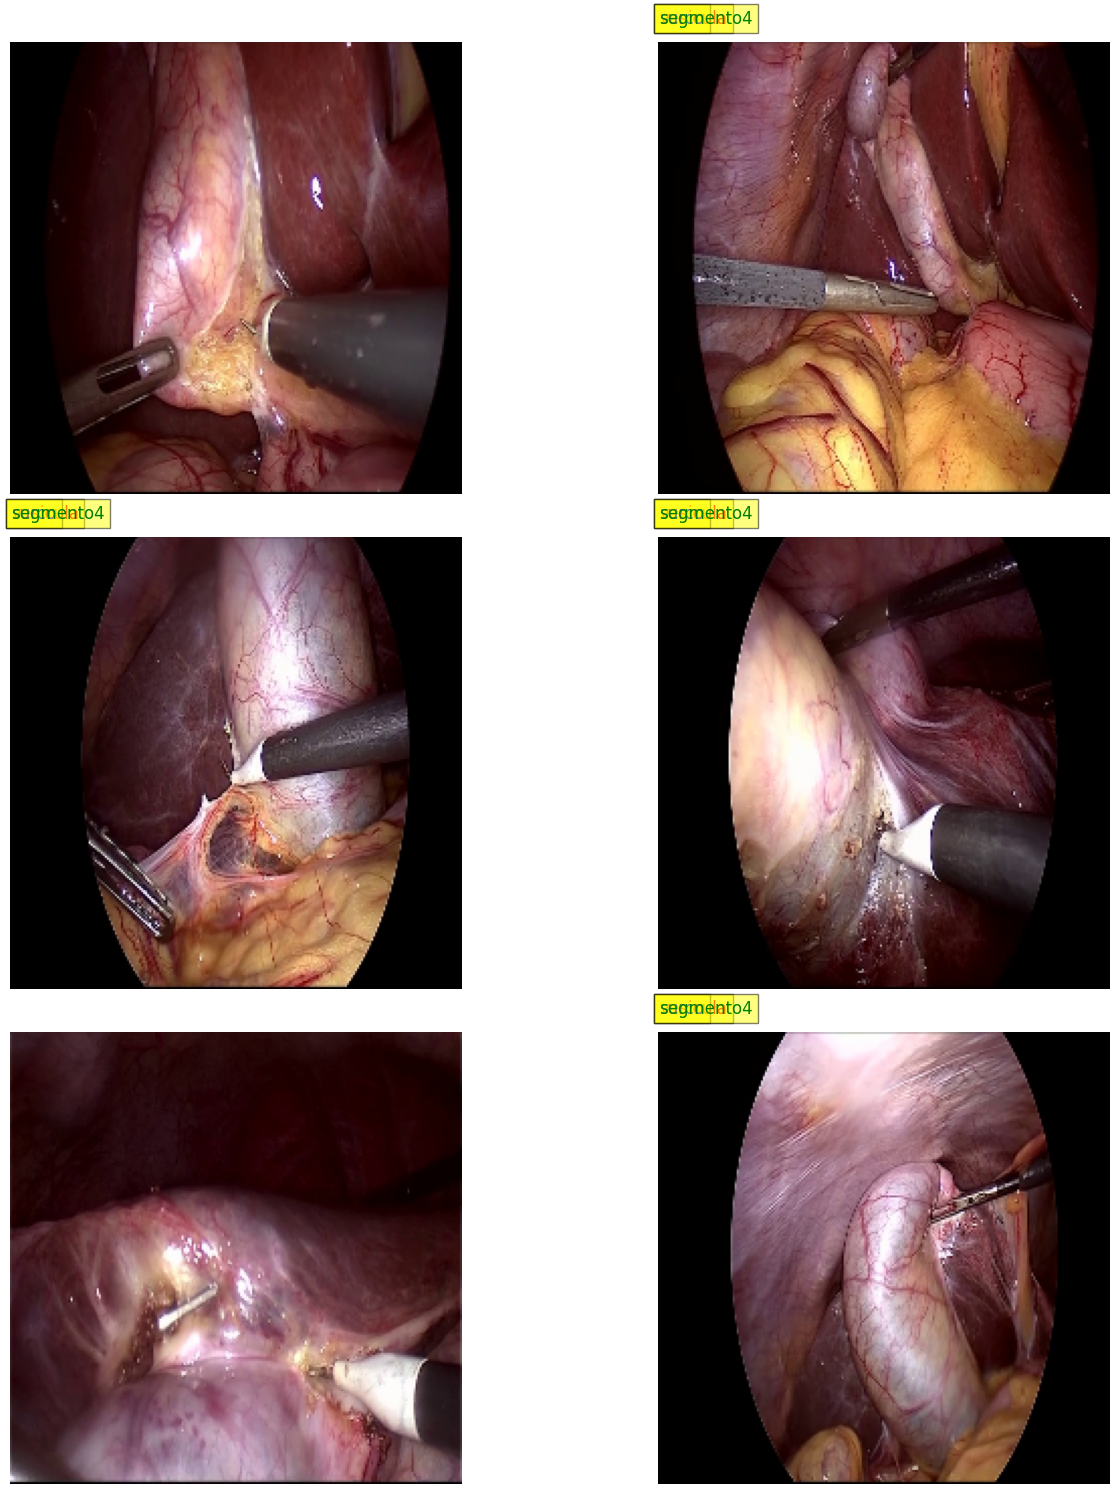

In [36]:
visualize_bounding_boxes(X_train,train_targets,6,2)

In [37]:
def normalize_bounding_boxes(bboxes, image_width, image_height):
    """
    Normaliza los bounding boxes para que estén en el rango [0, 1].
    
    Parámetros:
    -----------
    bboxes : np.array
        Array con los bounding boxes (x_min, y_min, x_max, y_max).
    image_width : int
        Ancho de la imagen.
    image_height : int
        Alto de la imagen.
        
    Retorno:
    --------
    np.array : Bounding boxes normalizados.
    """
    bboxes[:, :, [0, 2]] /= image_width  
    bboxes[:, :, [1, 3]] /= image_height  
    return bboxes


In [38]:

image_width = 224
image_height = 224

train_targets['bounding_box'] = normalize_bounding_boxes(train_targets['bounding_box'], image_width, image_height)


val_targets['bounding_box'] = normalize_bounding_boxes(val_targets['bounding_box'], image_width, image_height)


In [39]:
print(np.min(train_targets['bounding_box']), np.max(train_targets['bounding_box']))
print(np.min(val_targets['bounding_box']), np.max(val_targets['bounding_box']))


0.0 0.9979166666666667
0.0 1.0


In [40]:
train_targets['bounding_box'] = np.array(train_targets['bounding_box'])


val_targets['bounding_box'] = np.array(val_targets['bounding_box'])



## **Resumen del modelo entrenado**

In [41]:
print("GPUs disponibles: ", tf.config.list_physical_devices('GPU'))


GPUs disponibles:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [42]:
import tensorflow as tf

def iou_metric(y_true, y_pred):
    def box_area(box):
        return tf.maximum(0.0, (box[..., 2] - box[..., 0])) * tf.maximum(0.0, (box[..., 3] - box[..., 1]))

    true_area = box_area(y_true)
    pred_area = box_area(y_pred)

    # Calcular las coordenadas de intersección
    x_min = tf.maximum(y_true[..., 0], y_pred[..., 0])
    y_min = tf.maximum(y_true[..., 1], y_pred[..., 1])
    x_max = tf.minimum(y_true[..., 2], y_pred[..., 2])
    y_max = tf.minimum(y_true[..., 3], y_pred[..., 3])

    intersection_area = tf.maximum(0.0, x_max - x_min) * tf.maximum(0.0, y_max - y_min)

    union_area = true_area + pred_area - intersection_area

    # Calcular IoU,verifica no dividir por cero
    iou = intersection_area / tf.maximum(union_area, 1e-10)


    return tf.reduce_mean(iou)


In [43]:
def ciou_loss(y_true, y_pred):

    
    y_true = tf.clip_by_value(y_true, 0.0, 1.0)
    y_pred = tf.clip_by_value(y_pred, 0.0, 1.0)


    x_true, y_true, w_true, h_true = tf.split(y_true, 4, axis=-1)
    x_pred, y_pred, w_pred, h_pred = tf.split(y_pred, 4, axis=-1)

    x_center_true = x_true + w_true / 2.0
    y_center_true = y_true + h_true / 2.0
    x_center_pred = x_pred + w_pred / 2.0
    y_center_pred = y_pred + h_pred / 2.0

    # Área de los cuadros delimitadores
    area_true = w_true * h_true
    area_pred = w_pred * h_pred

    # Coordenadas de las esquinas para la caja envolvente mínima
    x_min_true = x_center_true - w_true / 2.0
    y_min_true = y_center_true - h_true / 2.0
    x_max_true = x_center_true + w_true / 2.0
    y_max_true = y_center_true + h_true / 2.0

    x_min_pred = x_center_pred - w_pred / 2.0
    y_min_pred = y_center_pred - h_pred / 2.0
    x_max_pred = x_center_pred + w_pred / 2.0
    y_max_pred = y_center_pred + h_pred / 2.0

    # Calcular intersección
    x_min_inter = tf.maximum(x_min_true, x_min_pred)
    y_min_inter = tf.maximum(y_min_true, y_min_pred)
    x_max_inter = tf.minimum(x_max_true, x_max_pred)
    y_max_inter = tf.minimum(y_max_true, y_max_pred)

    inter_area = tf.maximum(0.0, x_max_inter - x_min_inter) * tf.maximum(0.0, y_max_inter - y_min_inter)
    union_area = area_true + area_pred - inter_area

    # IoU
    iou = inter_area / (union_area + tf.keras.backend.epsilon())

    # Coordenadas de la caja envolvente mínima
    x_min_c = tf.minimum(x_min_true, x_min_pred)
    y_min_c = tf.minimum(y_min_true, y_min_pred)
    x_max_c = tf.maximum(x_max_true, x_max_pred)
    y_max_c = tf.maximum(y_max_true, y_max_pred)

    # Área de la caja envolvente mínima
    c_area = (x_max_c - x_min_c) * (y_max_c - y_min_c)

    # Distancia euclidiana entre los centros de los cuadros delimitadores
    center_dist = tf.square(x_center_true - x_center_pred) + tf.square(y_center_true - y_center_pred)

    # Agregar el término de penalización de distancia
    ciou = iou - (center_dist / (c_area + tf.keras.backend.epsilon()))

    # Minimizar la pérdida
    loss = 1.0 - ciou
    return tf.reduce_mean(loss)

In [44]:
def regression_loss(y_true, y_pred):
    # Pérdida MSE para bounding boxes
    return tf.reduce_mean(tf.square(y_true - y_pred))

In [45]:
def combined_ciou_regression_loss(y_true, y_pred):
    # Combinación de CIoU y pérdida de regresión
    return ciou_loss(y_true, y_pred) + 0.5 * regression_loss(y_true, y_pred)

In [46]:
def create_detection_model(input_shape=(224, 224, 3), num_bboxes=3):

    image_input = Input(shape=input_shape, name='image_input')

    # Bloques convolucionales 
    x = Conv2D(32, (3, 3), padding='same')(image_input)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)


    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)


    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

  
    x = GlobalMaxPooling2D()(x)

    # Capas completamente conectadas 
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Capa de salida para los bounding boxes
    bounding_box_output = Dense(num_bboxes * 4, activation='sigmoid')(x)
    bounding_box_output = Reshape((num_bboxes, 4), name='bounding_box_output')(bounding_box_output)

    
    model = Model(inputs=image_input, outputs=bounding_box_output)

   
    model.compile(optimizer=Adam(learning_rate=0.0001), loss=combined_ciou_regression_loss, metrics=['mae',iou_metric])

    model.summary()
    return model

In [47]:
tf.keras.backend.clear_session()

In [48]:
model = create_detection_model() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496 

In [49]:
print(model.output_names)

['bounding_box_output']


In [50]:
# Entrenar el modelo
history = model.fit(
    X_train,  
    train_targets['bounding_box'],  
    validation_data=(X_val, val_targets['bounding_box']),  
    epochs=50,  
    batch_size=32  
)

Epoch 1/50
73/73 [==============================] - 37s 221ms/step - loss: 1.7814 - mae: 0.5071 - iou_metric: 0.0185 - val_loss: 1.6029 - val_mae: 0.3782 - val_iou_metric: 0.0453
Epoch 2/50
73/73 [==============================] - 11s 156ms/step - loss: 1.5294 - mae: 0.4555 - iou_metric: 0.0246 - val_loss: 1.5380 - val_mae: 0.3924 - val_iou_metric: 0.0428
Epoch 3/50
73/73 [==============================] - 12s 160ms/step - loss: 1.5162 - mae: 0.4528 - iou_metric: 0.0252 - val_loss: 1.5326 - val_mae: 0.3989 - val_iou_metric: 0.0411
Epoch 4/50
73/73 [==============================] - 12s 160ms/step - loss: 1.4942 - mae: 0.4443 - iou_metric: 0.0266 - val_loss: 1.5188 - val_mae: 0.3778 - val_iou_metric: 0.0385
Epoch 5/50
73/73 [==============================] - 11s 158ms/step - loss: 1.4770 - mae: 0.4355 - iou_metric: 0.0276 - val_loss: 1.5090 - val_mae: 0.3656 - val_iou_metric: 0.0393
Epoch 6/50
73/73 [==============================] - 11s 151ms/step - loss: 1.4505 - mae: 0.4130 - iou_met

In [55]:
evaluation_results = model.evaluate(
    X_val,  
    val_targets['bounding_box'],  
    batch_size=32  
)
print(f"Resultados de la evaluación: {model.metrics_names}")
print(f"Valores de evaluación: {evaluation_results}")


19/19 [==============================] - 1s 63ms/step - loss: 0.7977 - mae: 0.0213 - iou_metric: 0.1647
Resultados de la evaluación: ['loss', 'mae', 'iou_metric']
Valores de evaluación: [0.797735869884491, 0.021272078156471252, 0.1646536886692047]


In [56]:
pred_bboxes = model.predict(X_val)


print("Predicciones de bounding boxes para la primera imagen:")
print(pred_bboxes[12])  

print("Bounding boxes verdaderos para la primera imagen:")
print(val_targets['bounding_box'][12])  


19/19 [==============================] - 2s 83ms/step
Predicciones de bounding boxes para la primera imagen:
[[0.36331955 0.04026913 0.5797183  0.6502998 ]
 [0.44014144 0.65126014 0.59323174 0.86957765]
 [0.56498456 0.32228422 0.7789026  0.50652695]]
Bounding boxes verdaderos para la primera imagen:
[[0.36885246 0.03125    0.60187354 0.59791667]
 [0.42271663 0.6625     0.60772834 0.82916667]
 [0.63583138 0.34166667 0.84543326 0.47083333]]


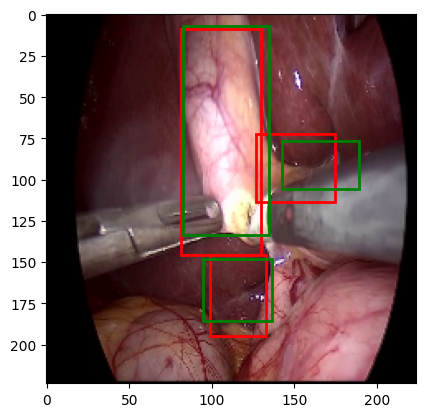

In [57]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


image_size = 224


img = X_val[12]


pred_box = pred_bboxes[12]
true_box = val_targets['bounding_box'][12]


fig, ax = plt.subplots(1)
ax.imshow(img)

pred_box_scaled = pred_box * image_size
true_box_scaled = true_box * image_size

# Añadir las cajas predichas (en rojo)
for box in pred_box_scaled:
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# Añadir las cajas verdaderas (en verde)
for box in true_box_scaled:
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(rect)


plt.show()



In [58]:
val_targets['bounding_box'][12]

array([[0.36885246, 0.03125   , 0.60187354, 0.59791667],
       [0.42271663, 0.6625    , 0.60772834, 0.82916667],
       [0.63583138, 0.34166667, 0.84543326, 0.47083333]])